# Decision Tree Classifier Implementation

## 1. Tools and Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.preprocessing import OneHotEncoder
from math import log2

## 2. Tree Node Class
The `Node` class represents a single node in a decision tree structure. It is used to store information about a decision point (for internal nodes) or a predicted value (for leaf nodes).


In [2]:
class Node:
  def __init__(self, left=None, right=None, info_gain=None, feature_index=None, threshold=None, value=None):
    self.left = left
    self.right = right
    self.info_gain = info_gain  # Information gain of split
    self.feature_index = feature_index  # Index of feature to split on
    self.threshold = threshold  # Threshold value to split on
    self.value = value  # Predicted value if node is leaf

## 3. Decision Tree Class
The `DecisionTreeClassifier` class implements a basic decision tree classifier. It recursively splits the feature space based on information gain, building a binary tree structure to classify data points.

In [3]:
class DecisionTreeClassifier:
    def __init__(self, max_depth=7, min_samples_split=10):
        """Initialize the decision tree with hyperparameters."""
        self.max_depth = max_depth  # Maximum depth of the tree
        self.min_samples_split = min_samples_split  # Minimum samples required to split a node
        self.root = None  # Root node of the tree, starts as None

    def fit(self, X, y):
        """Train the decision tree using the input features X and target y."""
        self.root = self.build_tree(X, y)  # Build the tree and set the root

    def predict(self, X):
        """Make predictions for each sample in X."""
        if self.root is None:
            raise ValueError("Model has not been trained. Please call 'fit' method first.")
        # Return predictions by traversing the tree for each sample
        return [self.make_prediction(x, self.root) for x in X]

    def make_prediction(self, x, node):
        """Recursively traverse the tree to make a prediction for a single sample."""
        if node.value is not None:  # Leaf node reached
            return node.value
        # Decide which subtree to follow based on the feature value
        if x[node.feature_index] <= node.threshold:
            return self.make_prediction(x, node.left)
        else:
            return self.make_prediction(x, node.right)

    def print_tree(self, feature_names):
        """Print the structure of the decision tree."""
        self.print_tree_helper(self.root, 0, feature_names)  # Start from the root with depth 0

    def print_tree_helper(self, node, depth, feature_names):
        """Helper method to recursively print the tree with indentation."""
        if node is None:
            return
        indent = " " * depth  # Indentation for visual hierarchy
        if node.value is not None:  # Leaf node
            print(f"{indent}Predict: {node.value}")
        else:  # Internal node
            print(f"{indent}{feature_names[node.feature_index]} <= {node.threshold} -> True:")
            self.print_tree_helper(node.left, depth + 1, feature_names)
            print(f"{indent}{feature_names[node.feature_index]} > {node.threshold} -> False:")
            self.print_tree_helper(node.right, depth + 1, feature_names)

    def build_tree(self, X, y, depth=0):
        """Recursively build the decision tree."""
        m, n = X.shape  # Number of samples (m) and features (n)
        is_pure = len(np.unique(y)) == 1  # Check if all labels are the same

        # Base case: stop if max depth reached, data is pure, or too few samples
        if depth >= self.max_depth or is_pure or m < self.min_samples_split:
            majority_class = self.compute_output(y)  # Assign majority class to leaf
            return Node(value=majority_class)

        # Find the best split and recursively build left and right subtrees
        best_split = self.get_best_split(X, y)
        left_indices = best_split['left']
        right_indices = best_split['right']
        left_subtree = self.build_tree(X[left_indices, :], y[left_indices], depth + 1)
        right_subtree = self.build_tree(X[right_indices, :], y[right_indices], depth + 1)

        # Return a node with the split details and subtrees
        return Node(left=left_subtree,
                    right=right_subtree,
                    info_gain=best_split['info_gain'],
                    feature_index=best_split['feature_index'],
                    threshold=best_split['threshold'])

    def get_best_split(self, X, y):
        """Find the best feature and threshold to split the data."""
        _, n = X.shape
        best_split = {
            'info_gain': float('-inf'),
            'threshold': None,
            'feature_index': None,
            'left': None,
            'right': None
        }

        # Iterate over all features and their unique values as potential thresholds
        for feature_index in range(n):
            feature_values = X[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            for threshold in possible_thresholds:
                # Split data based on the threshold
                left_indices = X[:, feature_index] <= threshold
                right_indices = X[:, feature_index] > threshold
                left_y = y[left_indices]
                right_y = y[right_indices]

                if len(left_y) == 0 or len(right_y) == 0:
                    continue
                
                # Calculate information gain for this split
                split_info_gain = self.compute_information_gain(y, left_y, right_y)

                # Update best split if this one is better
                if split_info_gain > best_split['info_gain']:
                    best_split['info_gain'] = split_info_gain
                    best_split['feature_index'] = feature_index
                    best_split['threshold'] = threshold
                    best_split['left'] = left_indices
                    best_split['right'] = right_indices

        return best_split

    def compute_output(self, y):
        """Compute the majority class for a leaf node."""
        unique_classes, frequency = np.unique(y, return_counts=True)
        majority_class = unique_classes[np.argmax(frequency)]  # Most frequent class
        # majority_count = frequency.max()
        # print(f"\nMajority Class: {majority_class} (Count: {majority_count})")
        return int(majority_class)

    def compute_entropy(self, y):
        """Calculate the entropy of a set of labels."""
        unique_classes, frequencies = np.unique(y, return_counts=True)
        n_classes = len(y)
        entropy = 0
        for frequency in frequencies:
            probability = frequency / n_classes
            entropy -= probability * log2(probability) if probability > 0 else 0
        return entropy

    def compute_information_gain(self, y, left_y, right_y):
        """Calculate information gain from a split."""
        m = len(y)
        left_m = len(left_y)
        right_m = len(right_y)

        # Entropy before and after the split
        parent_entropy = self.compute_entropy(y)
        left_entropy = self.compute_entropy(left_y) if left_m > 0 else 0
        right_entropy = self.compute_entropy(right_y) if right_m > 0 else 0

        # Weighted average of child entropies
        weighted_entropy = (left_m / m) * left_entropy + (right_m / m) * right_entropy
        information_gain = parent_entropy - weighted_entropy
        return information_gain

## 4. Loading and Preprocessing the Dataset

In [4]:
# Load the dataset
heart_df = pd.read_csv('heart.csv')
heart_df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [5]:
# Encode categorical features using One-Hot Encoding
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_features = encoder.fit_transform(heart_df[categorical_features])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))
modified_df = pd.concat([heart_df.drop(categorical_features, axis=1), encoded_df], axis=1)

modified_df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377,0.789760,0.188453,0.221133,0.050109,0.601307,0.193900,0.404139,0.501089,0.430283
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414,0.407701,0.391287,0.415236,0.218289,0.489896,0.395567,0.490992,0.500271,0.495386
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
# Split the dataset into training, validation, and test sets
X = modified_df.drop('HeartDisease', axis=1)
y = modified_df['HeartDisease']

# Split the dataset into training, validation (80%) and test (20%) sets, maintaining class distribution
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Split the training set into training (70%) and validation (10%) sets, maintaining class distribution
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=42, stratify=y_temp)

# Convert to NumPy arrays
X_train = X_train.to_numpy()
X_val = X_val.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

print(np.sum(y_train == 1) / len(y_train))
print(np.sum(y_val == 1) / len(y_val))
print(np.sum(y_test == 1) / len(y_test))

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

0.5529595015576324
0.5543478260869565
0.5543478260869565
(642, 15)
(92, 15)
(184, 15)


## 5. Training the Decision Tree Classifier

In [7]:
# Initialize and train the Decision Tree Classifier
decision_tree_classifier = DecisionTreeClassifier()
decision_tree_classifier.fit(X_train, y_train)

## 6. Hyperparameter Tuning
We will tune the hyperparameters `max_depth` and `min_samples_split` using the validation set.

In [8]:
def plot_confusion_matrix(cm):
    """Plot the confusion matrix."""
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, cmap='Blues', interpolation='nearest')
    plt.title('Confusion Matrix')
    plt.colorbar(label='Count')
    plt.xticks([0, 1], ['Predicted 0', 'Predicted 1'])
    plt.yticks([0, 1], ['True 0', 'True 1'])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [9]:
# Tune hyperparameters
max_depth_values = [2, 3, 5, 7, 9, 11, 13, 15]
min_samples_split_values = [2, 5, 10, 15, 20, 25, 30]
misclassification_rates = np.zeros((len(max_depth_values), len(min_samples_split_values)))

for i, max_depth in enumerate(max_depth_values):
    for j, min_samples_split in enumerate(min_samples_split_values):
        decision_tree_classifier = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split)
        decision_tree_classifier.fit(X_train, y_train)
        y_pred = decision_tree_classifier.predict(X_val)
        # cm = confusion_matrix(y_val, y_pred)
        # plot_confusion_matrix(cm)
        misclassification_rates[i, j] = np.mean(y_pred != y_val)
        print(f"Misclassification Rate (Depth={max_depth}, MinSamplesSplit={min_samples_split}): {misclassification_rates[i, j]}")
    print("")

Misclassification Rate (Depth=2, MinSamplesSplit=2): 0.20652173913043478
Misclassification Rate (Depth=2, MinSamplesSplit=5): 0.20652173913043478
Misclassification Rate (Depth=2, MinSamplesSplit=10): 0.20652173913043478
Misclassification Rate (Depth=2, MinSamplesSplit=15): 0.20652173913043478
Misclassification Rate (Depth=2, MinSamplesSplit=20): 0.20652173913043478
Misclassification Rate (Depth=2, MinSamplesSplit=25): 0.20652173913043478
Misclassification Rate (Depth=2, MinSamplesSplit=30): 0.20652173913043478

Misclassification Rate (Depth=3, MinSamplesSplit=2): 0.18478260869565216
Misclassification Rate (Depth=3, MinSamplesSplit=5): 0.18478260869565216
Misclassification Rate (Depth=3, MinSamplesSplit=10): 0.18478260869565216
Misclassification Rate (Depth=3, MinSamplesSplit=15): 0.18478260869565216
Misclassification Rate (Depth=3, MinSamplesSplit=20): 0.18478260869565216
Misclassification Rate (Depth=3, MinSamplesSplit=25): 0.18478260869565216
Misclassification Rate (Depth=3, MinSampl

Best Max Depth: 3
Best Min Samples Split: 2
Misclassification Rate: 0.24456521739130435
Accuracy: 0.7554347826086957
F1-Score: 0.789


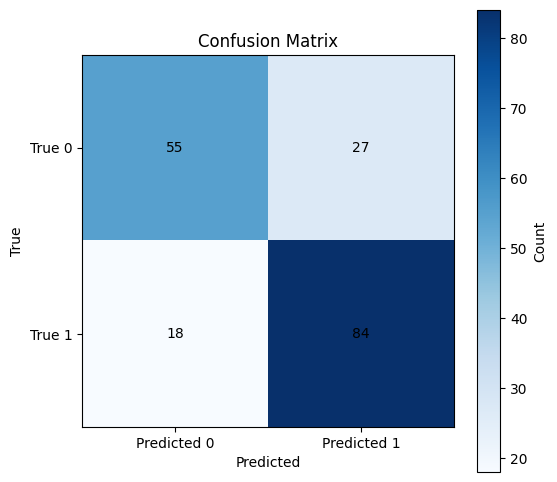

ST_Slope_Up <= 0.0 -> True:
 MaxHR <= 142.0 -> True:
  Sex_M <= 0.0 -> True:
   Predict: 1
  Sex_M > 0.0 -> False:
   Predict: 1
 MaxHR > 142.0 -> False:
  Cholesterol <= 190.0 -> True:
   Predict: 1
  Cholesterol > 190.0 -> False:
   Predict: 1
ST_Slope_Up > 0.0 -> False:
 Oldpeak <= 0.4 -> True:
  Age <= 55.0 -> True:
   Predict: 0
  Age > 55.0 -> False:
   Predict: 0
 Oldpeak > 0.4 -> False:
  MaxHR <= 132.0 -> True:
   Predict: 1
  MaxHR > 132.0 -> False:
   Predict: 0


In [10]:
# Find the best hyperparameters
best_idx = np.unravel_index(np.argmin(misclassification_rates, axis=None), misclassification_rates.shape)
best_max_depth = max_depth_values[best_idx[0]]
best_min_samples_split = min_samples_split_values[best_idx[1]]
print(f"Best Max Depth: {best_max_depth}")
print(f"Best Min Samples Split: {best_min_samples_split}")

# Intialize and train the Decision Tree Classifier with the best hyperparameters
decision_tree_classifier = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_split=best_min_samples_split)
decision_tree_classifier.fit(X_train, y_train)

# Make predictions and evaluate the model on the test set
y_pred = decision_tree_classifier.predict(X_test)

# Calculate the misclassification rate, accuracy, F1-score, and confusion matrix
misclassification_rate = np.mean(y_pred != y_test)
print(f"Misclassification Rate: {misclassification_rate}")

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

f1 = f1_score(y_test, y_pred)
print(f"F1-Score: {f1:.3f}")

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

# Print the structure of the decision tree
decision_tree_classifier.print_tree(feature_names=X.columns)

Accuracy: 0.7554347826086957


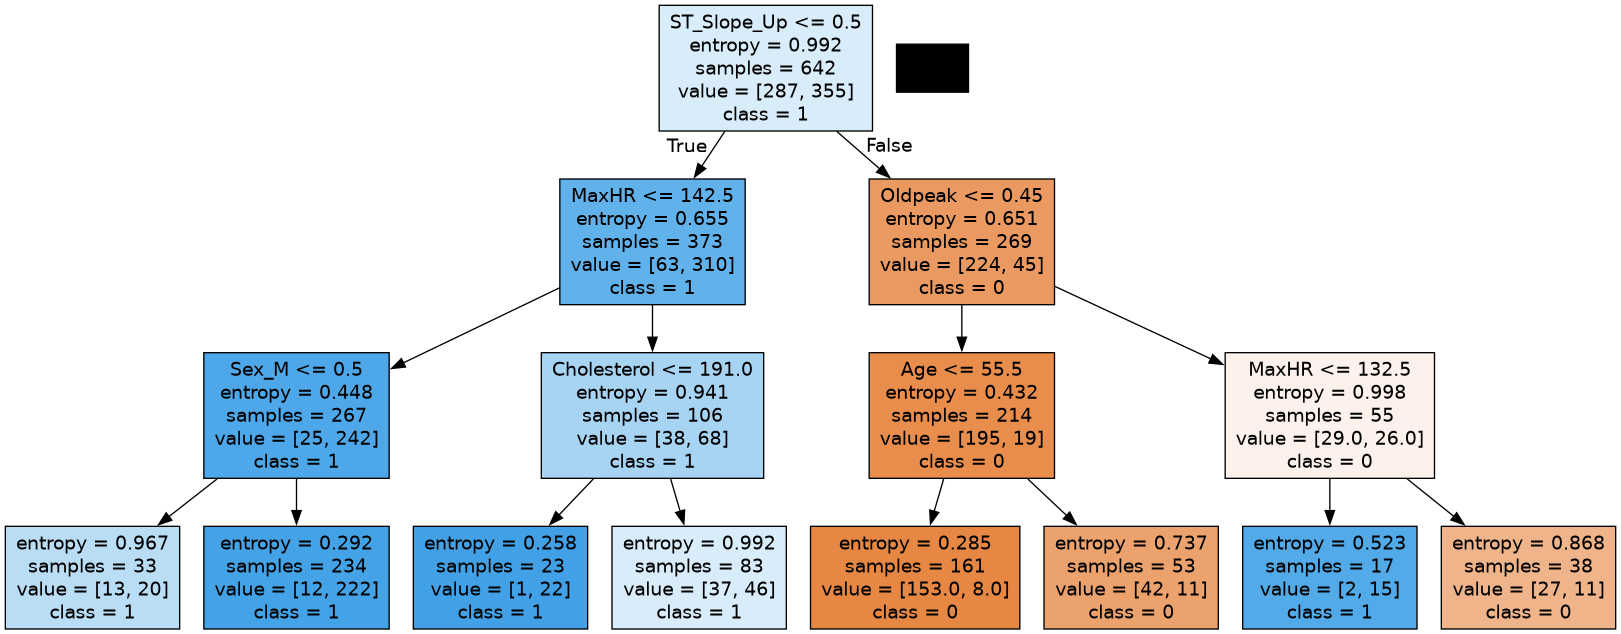

In [11]:
# Compare with Scikit-Learn's Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier as SklearnDecisionTreeClassifier
from IPython.display import Image
from sklearn import tree
import pydotplus

decisiontree = SklearnDecisionTreeClassifier(
    max_depth=best_max_depth, min_samples_split=best_min_samples_split, 
    criterion='entropy', random_state=42
    )

model = decisiontree.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

dot_data = tree.export_graphviz(decisiontree, out_file=None, feature_names=X.columns, class_names=['0', '1'], filled=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())